# PRM Implementation

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import random

## Path Planning in 2D with no obstacles using PRM

In [2]:
# Define parameters
xdim=10
ydim=10
numNodes=200
radius=1.25

init_node=(2,2)
fin_node=(8,8)

In [3]:
# Initialize list of vertices and edges
V=[]
E=[]
cost=[]
prev=[]

# Calculate Euclidean distance
def dist(a,b):
    d=np.sqrt((b[0]-a[0])**2+(b[1]-a[1])**2)
    return d

# Find all the nodes that are within a specified distance from the new node
def find_near(V,n_new,rad):
    n_nearest=[]
    distance=[]
    if V:
        for vertex in V:
            d=dist(vertex,n_new)
            if d<rad:
                n_nearest.append(vertex)
    return n_nearest

# Find if an edge already exists between 2 vertices
def same_comp(node1,node2,E):
    for e in E:
        if e==(node1,node2) or e==(node2,node1):
            return True
    return False

# Connect a node (start and goal) to all nodes that are within a specified distance
def connect_pt(node,V,rad):
    connected=[]
    for vertex in V:
        if dist(vertex,node)<rad:
            connected.append(vertex)
    return connected

# Find the neighbor nodes from E
def find_neighbor(node,E):
    neighbor=[]
    for e in E:
        if e[0]==node:
            neighbor.append(e[1])
        elif e[1]==node:
            neighbor.append(e[0])
    return neighbor

# Create the roadmap
for i in range(numNodes):
    n_new=(random.random()*xdim,random.random()*ydim)
    V.append(n_new)
    cost.append(float("inf"))
    prev.append(None)
    n_nearest=find_near(V,n_new,radius)
    for node in n_nearest:
        if not same_comp(node,n_new,E):
            E.append((node,n_new))

# Connect the start and goal nodes to the roadmap
s_conn=connect_pt(init_node,V,radius)
g_conn=connect_pt(fin_node,V,radius)
for node in s_conn:
    E.append((init_node,node))
for node in g_conn:
    E.append((node,fin_node))
V.append(fin_node)
cost.append(float("inf"))
prev.append(None)
V.append(init_node)
cost.append(0)
prev.append(None)
    
# Use Djikstra's algorithm to find the path
unvisited=list(V)
unvisited_cost=list(cost)
current_node=init_node

while unvisited:
    if current_node==fin_node:
        break
    neighbors=find_neighbor(current_node,E)
    for node in neighbors:
        d=dist(node,current_node)
        next_cost=cost[V.index(current_node)]+d
        ind=V.index(node)
        if next_cost<cost[ind]:
            prev[ind]=current_node
            cost[ind]=next_cost
            unvisited_cost[unvisited.index(node)]=next_cost
    ind_visited=unvisited.index(current_node)
    unvisited.pop(ind_visited)
    unvisited_cost.pop(ind_visited)
    current_node=unvisited[unvisited_cost.index(min(unvisited_cost))]

# Find the path
path=[]
path.append(fin_node)
path_ind=V.index(fin_node)
while True:
    path.append(prev[path_ind])
    if prev[path_ind] is init_node:
        break
    path_ind=V.index(prev[path_ind])
path.reverse()

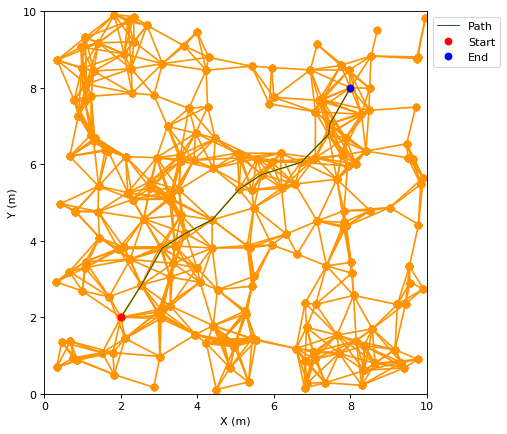

In [4]:
# Initialize the figure
fig=plt.figure(figsize=(8,6.333),dpi=80)
ax=fig.add_subplot(111,autoscale_on=False,xlim=(0,xdim),ylim=(0,ydim))
ax.set_aspect('equal')

# Plot the edges of the roadmap
for e in E:
    ax.plot([e[0][0],e[1][0]],[e[0][1],e[1][1]],'o-',color="#FF9300")
    
# Plot the found path
ax.plot([path_x[0] for path_x in path],[path_y[1] for path_y in path],color="#055200",linewidth=0.8,label='Path')
# Show the figure with appropritate info
ax.plot(init_node[0],init_node[1],'ro',label='Start')
ax.plot(fin_node[0],fin_node[1],'bo',label='End')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

## Path Planning in 2D with obstacles using PRM 

In [189]:
# Define parameters
xdim=10
ydim=10
numNodes=250
radius=1.5
div=10

init_node=(2,2)
fin_node=(8,8)

# Create a class for obstacles that are square
class Obstacle:
    def __init__(self,center,angle,length):
        self.center=(center[0],center[1])
        self.ang=angle                       # Angle in rads, positive direction CCW from +x axis
        self.length=length
        cos_val=np.cos(self.ang+np.pi/4)
        sin_val=np.sin(self.ang+np.pi/4)
        corner_length=np.sqrt(2)*self.length/2
        self.corner=np.array([[cos_val*corner_length+self.center[0],sin_val*corner_length+self.center[1]],
                              [-sin_val*corner_length+self.center[0],cos_val*corner_length+self.center[1]],
                              [-cos_val*corner_length+self.center[0],-sin_val*corner_length+self.center[1]],
                              [sin_val*corner_length+self.center[0],-cos_val*corner_length+self.center[1]],
                              [cos_val*corner_length+self.center[0],sin_val*corner_length+self.center[1]]])

# Create two square obstacles
obs1=Obstacle((5,5),-np.pi/8,1.5)
obs2=Obstacle((4.5,2.5),np.pi/4,1.5)

In [190]:
# Initialize list of vertices and edges
V=[]
E=[]
cost=[]
prev=[]

# Check collision of the point with an obstacle
def collision(obs,pt):
    box_to_pt=np.array([pt[0]-obs.center[0],pt[1]-obs.center[1]])
    box_to_pt_norm=box_to_pt/np.linalg.norm(box_to_pt)
    max_val=float("-inf")
    for i in range(4):
        obs_pt=obs.corner[i,:]
        v=np.array([obs_pt[0]-obs.center[0],obs_pt[1]-obs.center[1]])
        current_proj=np.matmul(v,box_to_pt_norm)
        if max_val<current_proj:
            max_val=current_proj
    if np.linalg.norm(box_to_pt)-max_val>0:
        return False
    return True

# Create the roadmap
for i in range(numNodes):
    n_new=(random.random()*xdim,random.random()*ydim)
    if not collision(obs1,n_new) and not collision(obs2,n_new):
        V.append(n_new)
        cost.append(float("inf"))
        prev.append(None)
        n_nearest=find_near(V,n_new,radius)
        for node in n_nearest:
            if not same_comp(node,n_new,E):
                intersect=False
                for i in range(div):
                    point=((i/div)*node[0]+(1-i/div)*n_new[0],(i/div)*node[1]+(1-i/div)*n_new[1])
                    if collision(obs1,point) or collision(obs2,point):
                        intersect=True
                        break
                if not intersect:
                    E.append((node,n_new))

# Connect the start and goal nodes to the roadmap
s_conn=connect_pt(init_node,V,radius)
g_conn=connect_pt(fin_node,V,radius)
for node in s_conn:
    E.append((init_node,node))
for node in g_conn:
    E.append((node,fin_node))
V.append(fin_node)
cost.append(float("inf"))
prev.append(None)
V.append(init_node)
cost.append(0)
prev.append(None)
    
# Use Djikstra's algorithm to find the path
unvisited=list(V)
unvisited_cost=list(cost)
current_node=init_node

while unvisited:
    if current_node==fin_node:
        break
    neighbors=find_neighbor(current_node,E)
    for node in neighbors:
        d=dist(node,current_node)
        next_cost=cost[V.index(current_node)]+d
        ind=V.index(node)
        if next_cost<cost[ind]:
            prev[ind]=current_node
            cost[ind]=next_cost
            unvisited_cost[unvisited.index(node)]=next_cost
    ind_visited=unvisited.index(current_node)
    unvisited.pop(ind_visited)
    unvisited_cost.pop(ind_visited)
    current_node=unvisited[unvisited_cost.index(min(unvisited_cost))]

# Find the path
path=[]
path.append(fin_node)
path_ind=V.index(fin_node)
while True:
    path.append(prev[path_ind])
    if prev[path_ind] is init_node:
        break
    path_ind=V.index(prev[path_ind])
path.reverse()

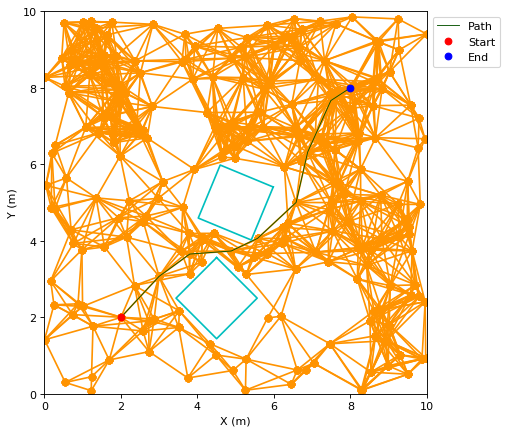

In [191]:
# Initialize the figure
fig=plt.figure(figsize=(8,6.333),dpi=80)
ax=fig.add_subplot(111,autoscale_on=False,xlim=(0,xdim),ylim=(0,ydim))
ax.set_aspect('equal')

# Plot the edges of the roadmap
for e in E:
    ax.plot([e[0][0],e[1][0]],[e[0][1],e[1][1]],'o-',color="#FF9300")

# Plot the found path
ax.plot([path_x[0] for path_x in path],[path_y[1] for path_y in path],color="#055200",linewidth=0.8,label='Path')

# Plot the obstacles
ax.plot([obs[0] for obs in obs1.corner],[obs[1] for obs in obs1.corner],'c-',
        [obs[0] for obs in obs2.corner],[obs[1] for obs in obs2.corner],'c-')

# Show the figure with appropritate info
ax.plot(init_node[0],init_node[1],'ro',label='Start')
ax.plot(fin_node[0],fin_node[1],'bo',label='End')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()